# *Clustering em Clientes de uma Loja*

<p align="center">
  <img src="https://raw.githubusercontent.com/rafaelgrecco/Imagens-datasets/master/clustering-algorithms-in-Machine-Learning.jpg"
     width="900" 
     height="500" >
</p>

***

Os dados que o dataset utilizado nos entrega são:

**Gender:** Sexo que o cliente se identifica.

**Age:** idade fornecida.

**Annual Income:** Receita anual fornecida.

**Spending Score:** Pontuação de crédito, quanto maior a pontuação melhor é o comportamento de gastos do cliente, tem um intervalo de 0 a 100.

**Profession:** Profissão fornecida pelo cliente.

**Work Experience:** Quantidade de anos de experiência no trabalho.

**Family Size:** Tamanho da família fornecido pelo cliente.

***

Com base nos dados fornecidos podemos analisar o comportamento de gastos/compras desses clientes com base em alguns critérios que vamos poder escolher mais adiante. Esses dados ao final do notebook poderão ajudar a compor um modelo para segmentar os clientes em grupos e esses grupos poderão servir para diversos propósitos dentro do estabelecimento.





# *Bibliotecas e configurações inicias*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objs import *

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import math
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler



pallete_color = ["#496595", "#c6ccd8", "#223843"]

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH_DATA = "/content/drive/MyDrive/processo_modal/data/Customers.csv"
df = pd.read_csv(PATH_DATA)
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


## *Informações sobre a qualidade dos dados e análise estatística*

In [3]:
df.rename(columns=
          {'Annual Income ($)':'annual_income', "Spending Score (1-100)":"spending_score", "Work Experience":"work_experience", "Family Size":"family_size"},
          inplace = True)
df.head()

,CustomerID,Gender,Age,annual_income,spending_score,Profession,work_experience,family_size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [4]:
df.shape

(2000, 8)

In [5]:
df=df.dropna()

In [6]:
df[["Age", "annual_income", "spending_score", "work_experience", "family_size"]].describe()

,Age,annual_income,spending_score,work_experience,family_size
count,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000
mean,48.894656,110616.009669,51.078880,4.092621,3.757252
std,28.414889,45833.860195,27.977176,3.926459,1.968335
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25.000000,74350.000000,28.000000,1.000000,2.000000
50%,48.000000,109759.000000,50.000000,3.000000,4.000000
75%,73.000000,149095.000000,75.000000,7.000000,5.000000
max,99.000000,189974.000000,100.000000,17.000000,9.000000


Não foi identificado nenhum outlier, partindo da análise do desvio padrão para com a média aritmética dos dados

# Análise exploratória

## *Vamos explorar caracteríesticas dos clientes com a finalidade compreender melhor a base de dados que estamos trabalhando*



In [7]:
fig = make_subplots(rows=2, cols=2,
                   specs=[[{'type':'bar'}, {'type':'pie'}],
                         [{'colspan':2}, None]],
                   column_widths=[0.5, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                   subplot_titles=('Profissões dos nossos clientes', 'Divisão sexual',
                                   'Distribuição da idade dos clientes'))

fig.add_trace(go.Bar(x=df['Profession'].value_counts().values, y=df['Profession'].value_counts().index,
                    marker=dict(color=pallete_color[0]), name='Family', orientation='h'), row=1, col=1)
 
fig.add_trace(go.Pie(values=df['Gender'].value_counts(), labels=['Feminino', 'Masculino'],
                     marker=dict(colors=pallete_color[:2]),hole=0.7, hoverinfo='label+percent+value',
                     textinfo='label'), row=1, col=2)

fig.add_trace(go.Bar(x=df['Age'].unique(), y=df['Age'].value_counts(), name='Family',
                    marker=dict(color=pallete_color[1])), row=2, col=1)

fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_traces(textposition='outside')
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Helvetica"),
                  font=dict(color=pallete_color[2]), 
                  hoverlabel=dict(bgcolor="#f2f2f3", font_size=12, font_family="Sans"),
                  showlegend=False)
fig.show()

A partir das informações aferidas nos gráfico mostrados anteriormente, podemos imputar algumas informações relevantes para que possamos compreender o padrão dos clientes do estabelecimento

> Podemos aferir que as 3 profissões que mais contribuem em compor a base de clientes são: Artistas, Profissionais da área da saúde e profissionais do entretenimento. 

***

> Outrossim, podemos concluir que a base de clientes é composta por mulheres. Clientes estes dispostos em diversas faixas etárias com um pico entre 20 e 30 anos.

## *Entendendo o poder de compra dos usuários*

In [8]:
fig = make_subplots(rows=2, cols=2,
                   specs=[[{'type':"bar"}, {'type':'Indicator'}],
                         [{'type':"bar"}, {"type":"indicator"}]],
                   column_widths=[0.5, 0.3], vertical_spacing=0.2, horizontal_spacing=0.02,
                   subplot_titles=('Pontuação de acordoo com a idade', "", "Pontuação com base na quantidade de<br>membros na família"))


f1 = df.groupby("Age")["spending_score"].median()[18:50]
best_prof = df.groupby("Profession")["spending_score"].mean().sort_values(ascending=False).index[0]
less_prof = df.groupby("Profession")["spending_score"].mean().sort_values(ascending=False).index[-1]

fig.add_trace(go.Bar(x=f1.index, y=f1.values, marker=dict(color=pallete_color[0]), name='Family', orientation='v'), row=1, col=1)

fig.add_trace(go.Indicator(mode='number', value=df.groupby("Profession")["spending_score"].mean().sort_values(ascending=False).values[0],
                          number={'font':{'color':'#A9BCD0','size':90}}, title={
                              "text":f"Profissão com a maior<br>média de pontuação: {best_prof}"}), row=1, col=2)

fig.add_trace(go.Bar(x=df.groupby("family_size")["spending_score"].mean().values, y=df.groupby("family_size")["spending_score"].mean().index,
                    marker=dict(color=pallete_color[1]), name='Family', orientation='h'), row=2, col=1)

fig.add_trace(go.Indicator(mode='number', value=df.groupby("Profession")["spending_score"].mean().sort_values(ascending=False).values[-1],
                          number={'font':{'color':'#A9BCD0','size':90}}, title={
                              "text":f"Profissão com a menor<br>média de pontuação: {less_prof}"}), row=2, col=2)

fig.update_annotations(font_size=20)
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=2, col=1)
fig.update_xaxes(visible=True, row=1, col=1)
fig.update_yaxes(visible=True, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  template="plotly_white",
                  font=dict(color=pallete_color[2]), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=12, font_family="Sans"),
                  showlegend=False)

fig.show()

Através dos últimos gráficos e indicadores podemos inferir algumas importantes informações, como: 
> O fator idade tem uma certa relevância, uma vez que podemos formular uma hipótese do motivo de haver um pico de pontuação com pessoas entre 20 e 25 anos e depois uma queda muito brusca, isso pode ocorrer devido ao maior número de oportunidades de créditos que a pessoa obtem após os 18 anos, mas que o descontrole das finanças pode levar ao endividamento, fenômeno que ocorre nos dias atuais.

> Além disso, podemos visualizar como a quantidade de pessoas em uma mesma família pode levar o indivíduo a ter uma pontuação de crédito menor, tal situação decorre muito provavelmente de endividamentos com gastos elementares como saúde e moradia.
***

Para que possamos compreender o poder de compra de forma mais ampla, podemos analisar a renda média anual dos indivíduos e ver como essa variável se comporta frente as demais.

In [9]:
fig = make_subplots(rows=2, cols=2,
                   specs=[[{'type':"bar"}, {'type':'Indicator'}],
                          [{'colspan':2}, None]],
                   column_widths=[0.5, 0.3], vertical_spacing=0.2, horizontal_spacing=0.02,
                   subplot_titles=('Renda anual média por profissão', "", "Renda anual média de acordo com as pontuações"))

annual_income = df.groupby("spending_score")["annual_income"].mean()
work_p_annual = df.groupby("Profession")["annual_income"].mean()


fig.add_trace(go.Bar(x=work_p_annual.values, y=work_p_annual.index,
                     marker=dict(color=pallete_color[1]), name='Family', orientation='h'), row=1, col=1)
fig.add_trace(go.Bar(x=annual_income.index, y=annual_income.values,
                     marker=dict(color=pallete_color[0]), name='Family', orientation='v'), row=2, col=1)
fig.add_trace(go.Indicator(mode='number', value=df.work_experience.mean(),
                          number={'font':{'color':'#A9BCD0','size':90}}, title={
                              "text":"Tempo médio de<br>experiência dos clientes<br>(Anos)"}), row=1, col=2)


fig.update_annotations(font_size=20)
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=2, col=1)
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  template="plotly_white",
                  font=dict(color=pallete_color[2]), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=12, font_family="Sans"),
                  showlegend=False)

fig.show()

# *Clustering*

> Clustering é um processo de agrupar os dados ou objetos semelhantes em clusters com base em seus atributos ou recursos.

***

Para realizar o clustering vamos inicialmente utilizar a técnica mais conhecida e aplicada para esse tipo de problema: K-means, que apesar de ser um algorítimo simples é extremanete poderoso e eficaz.

In [10]:
scaler=StandardScaler()
df[["spending_score","annual_income"]]=scaler.fit_transform(df[["spending_score","annual_income"]])

In [11]:
x = df[["annual_income", "spending_score"]]

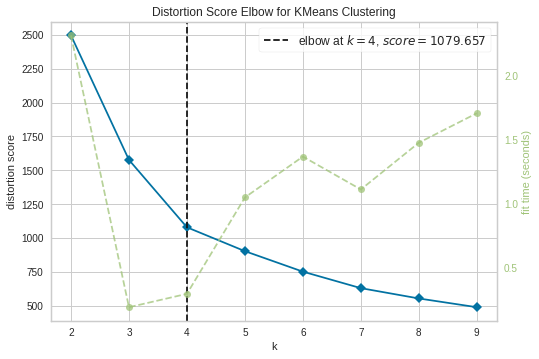

In [12]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(x)
visualizer.show()
plt.show()

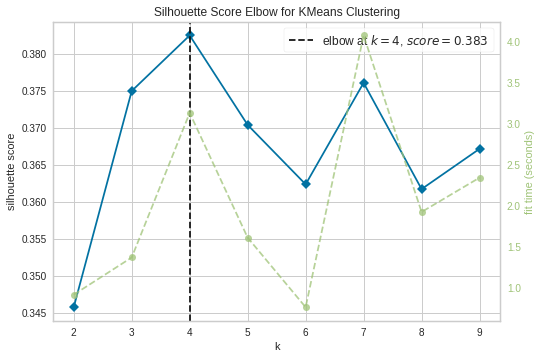

In [13]:
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric="silhouette")

visualizer.fit(x)
visualizer.show()
plt.show()

In [14]:
KM_4_clusters = KMeans(n_clusters=4, init="k-means++").fit(x)

KM4_clustered = x.copy()
KM4_clustered.loc[:,"Cluster"] = KM_4_clusters.labels_ 

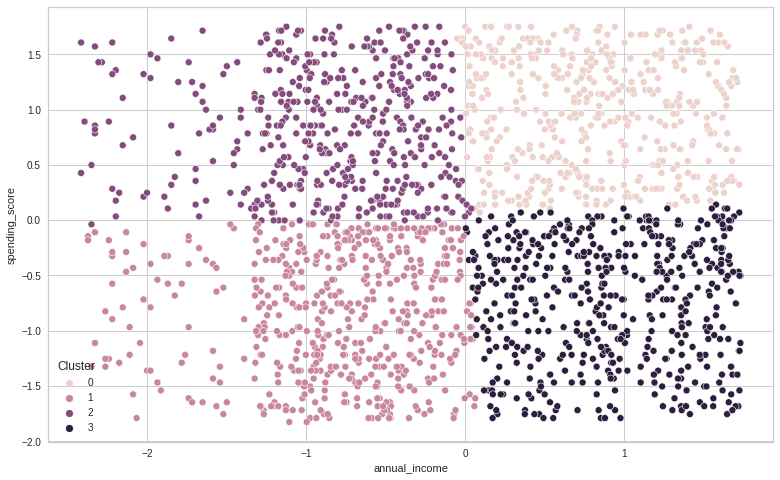

In [15]:
plt.figure(figsize=(13,8))
sns.scatterplot(x=KM4_clustered.annual_income,
                y=KM4_clustered.spending_score,
                hue=KM4_clustered["Cluster"])
plt.show();

Podemos visualizar que o modelo separou em 4 clusters com essas regras:

  * *Cluster 0*: alta renda anual e alta pontuação de crédito
  * *Cluster 1*: baixa renda anual e baixa pontuação de crédito
  * *Cluster 2*: baixa renda anual e alta pontuação de crédito
  * *Cluster 3*: alta renda anual e baixa pontuação de crédito


In [16]:
KM_clust_sizes = KM4_clustered.groupby("Cluster").size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,462
1,527
2,474
3,502


Analisando o tamanho dos clusters, conseguimos obervar que o maior cluster é o Cluster 1, que representa aqueles usuários com baixa renda anual e baixa pontuação de crédito. É interessante observar também que o menor Cluster é o número 0 (alto - alto), mostrando que a menor parcela dos clientes possuem uma renda alta e uma alta pontuação de crédito.

### *Limitações do K-means*

É importante ressaltar algumas limitações que o K-means possui, considerando que a conclusão do modelo está próxima.

> O modelo inicialmente inicializa os centróides de forma aleatória, o tornando sensível a inicialização, ou seja, podemos obter resultados diferentes em inicializações diversas.

> A escolha do número de clusters também é uma limitação do K-means, pois existem algumas técnicas, inclusive utilizadas neste projeto para aproximar o número ideal, mas considerando que é uma aproximação e que isso afeta o desempenho do modelo, é possível considerar isso uma limitação do modelo.

> Outra limitação imposta a nós pelo K-means é que ele assume no início da modelagem que os clusters são esféricos com dispersão (Variância) iguais, que pode ser requisitos não preenchidos em alguns conjuntos de dados, técnicas como DBSCAN ou hierarchical clustering podem oferecer suporte a clusters não esféricos

# *Conclusão*

Foi possível produzir clusters de forma satisfatória com o modelo K-means e tais grupos poderão ser úteis para campanhas do time de marketing e para que possamos compreender um pouco mais da nossa base de clientes entre outras possíveis aplicações. Para os próximos passos, talvez seja interessante abordar o problema com outras técnicas, como o modelo Affinity Propagation que não é sensível a inicializações, uma vez que ele é responsável por encontrar sozinho o seu número ótimo de clusters, a um custo de complexidade elevado, chegando a ordem de $O(n²T)$ onde $n$ é o número de amostras e $T$ a quantidade de interações até a convergência.